In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.layers import CuDNNLSTM,LSTM
from keras.models import Model
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

###Preprocessing the dataset with various attacks

In [3]:
def preprocessing_final(df):
  lamda = 1e-4
  df.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','Flow ID',' Source IP',' Source Port',' Destination IP',' Destination Port',' Timestamp','SimillarHTTP',' Inbound',' Fwd Header Length.1'],axis=1,inplace=True)
  df.replace(-np.inf, np.nan,inplace=True)
  df.replace(np.inf, np.nan,inplace=True)
  df.dropna(axis=0,inplace=True)
  cols = [' Label']
  # for col in df.columns:
  #   if len(np.unique(df.loc[:,col])) < 5:
  #     cols.append(col)
  # for col in df.columns:
  #   if col not in cols:
  #     df.loc[:,col] = (df.loc[:,col]-df.loc[:,col].min())/(df.loc[:,col].max()-df.loc[:,col].min())
  labels = np.unique(df.iloc[:,-1])
  for i in range(len(labels)):
    df.iloc[:,-1] = df.iloc[:,-1].replace(labels[i],i)
  df = df[[' Protocol',' Flow Duration','Flow Bytes/s',' Flow Packets/s','Fwd Packets/s',' Bwd Packets/s',' Total Fwd Packets',' Total Backward Packets',
  'Total Length of Fwd Packets',' Total Length of Bwd Packets', ' Fwd Packet Length Max',' Fwd Packet Length Min',' Fwd Packet Length Mean',' Fwd Packet Length Std',
   'Bwd Packet Length Max',' Bwd Packet Length Min',' Bwd Packet Length Mean',' Bwd Packet Length Std',
 ' Max Packet Length',' Min Packet Length',' Packet Length Mean',' Packet Length Std',' Packet Length Variance',' Fwd Header Length',' Bwd Header Length',
 ' min_seg_size_forward',' act_data_pkt_fwd',' Flow IAT Mean',' Flow IAT Max',' Flow IAT Min',' Flow IAT Std','Fwd IAT Total',' Fwd IAT Max',
 ' Fwd IAT Min',' Fwd IAT Mean',' Fwd IAT Std','Bwd IAT Total', ' Bwd IAT Max',' Bwd IAT Min',' Bwd IAT Mean',' Bwd IAT Std','Fwd PSH Flags',
 ' Bwd PSH Flags',' Fwd URG Flags', ' Bwd URG Flags','FIN Flag Count',' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count',
 ' ACK Flag Count', ' URG Flag Count',' ECE Flag Count',' Down/Up Ratio',' Average Packet Size','Init_Win_bytes_forward', ' Init_Win_bytes_backward',
 ' Active Max', ' Active Min','Active Mean',' Active Std',' Idle Max', ' Idle Min','Idle Mean', ' Idle Std','Fwd Avg Bytes/Bulk',
 ' Fwd Avg Packets/Bulk',' Bwd Avg Bytes/Bulk',' Bwd Avg Packets/Bulk',' Fwd Avg Bulk Rate','Bwd Avg Bulk Rate',' Avg Fwd Segment Size', ' Avg Bwd Segment Size',
 ' CWE Flag Count','Subflow Fwd Packets',' Subflow Bwd Packets',' Subflow Fwd Bytes',' Subflow Bwd Bytes',' Label'
]]
  return df

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Loading the dataset with various attacks

In [8]:
df = pd.read_csv("/content/drive/MyDrive/final_dataset.csv",low_memory=False)

In [9]:
df.shape

(1245798, 90)

###Splitting the data using random stratified sampling

In [10]:
train_df,valid_df = train_test_split(df,test_size=0.3,shuffle=True,stratify=df.iloc[:,-1])

In [ ]:
test_df = pd.read_csv("/content/flows.csv")

In [ ]:
[' Protocol',' Flow Duration','Flow Bytes/s',' Flow Packets/s','Fwd Packets/s',' Bwd Packets/s',' Total Fwd Packets',' Total Backward Packets',
  'Total Length of Fwd Packets',' Total Length of Bwd Packets', ' Fwd Packet Length Max',' Fwd Packet Length Min',' Fwd Packet Length Mean',' Fwd Packet Length Std',
   'Bwd Packet Length Max',' Bwd Packet Length Min',' Bwd Packet Length Mean',' Bwd Packet Length Std',
 ' Max Packet Length',' Min Packet Length',' Packet Length Mean',' Packet Length Std',' Packet Length Variance',' Fwd Header Length',' Bwd Header Length',
 ' min_seg_size_forward',' act_data_pkt_fwd',' Flow IAT Mean',' Flow IAT Max',' Flow IAT Min',' Flow IAT Std','Fwd IAT Total',' Fwd IAT Max',
 ' Fwd IAT Min',' Fwd IAT Mean',' Fwd IAT Std','Bwd IAT Total', ' Bwd IAT Max',' Bwd IAT Min',' Bwd IAT Mean',' Bwd IAT Std','Fwd PSH Flags',
 ' Bwd PSH Flags',' Fwd URG Flags', ' Bwd URG Flags','FIN Flag Count',' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count',
 ' ACK Flag Count', ' URG Flag Count',' ECE Flag Count',' Down/Up Ratio',' Average Packet Size','Init_Win_bytes_forward', ' Init_Win_bytes_backward',
 ' Active Max', ' Active Min','Active Mean',' Active Std',' Idle Max', ' Idle Min','Idle Mean', ' Idle Std','Fwd Avg Bytes/Bulk',
 ' Fwd Avg Packets/Bulk',' Bwd Avg Bytes/Bulk',' Bwd Avg Packets/Bulk',' Fwd Avg Bulk Rate','Bwd Avg Bulk Rate',' Avg Fwd Segment Size', ' Avg Bwd Segment Size',
 ' CWE Flag Count','Subflow Fwd Packets',' Subflow Bwd Packets',' Subflow Fwd Bytes',' Subflow Bwd Bytes',' Label'
]

In [ ]:
test_df.drop(['src_ip','dst_ip','src_port','dst_port','timestamp'],axis=1,inplace=True)

In [11]:
np.unique(train_df.iloc[:,-1])

array(['BENIGN', 'LDAP', 'MSSQL', 'NetBIOS', 'Portmap', 'Syn', 'UDP',
       'UDPLag'], dtype=object)

###Preprocessing the data



In [12]:
train_df = preprocessing_final(train_df)
valid_df = preprocessing_final(valid_df)

In [13]:
BATCH_SIZE = 100
NUM_OF_CLASSES = len(np.unique(df.iloc[:,-1]))
EPOCHS = 10

In [14]:
x_train,y_train = train_df.iloc[:,:-1],train_df.iloc[:,-1]
x_valid,y_valid = valid_df.iloc[:,:-1],valid_df.iloc[:,-1]

In [15]:
x_train = x_train.to_numpy()
x_valid = x_valid.to_numpy()
y_train = y_train.to_numpy()
y_valid = y_valid.to_numpy()

In [ ]:
from sklearn.manifold import TSNE

x_embedded = TSNE(n_components=2, learning_rate=30, perplexity=20).fit_transform(x_train)

plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c = y_train)
plt.title("Visualisation of Dataset of DDoS Attacks")
plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


###Standardizing the data

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler = scaler.fit(x_train)

In [ ]:
x_train = scaler.transform(x_train)

In [ ]:
x_valid = scaler.transform(x_valid)

***************************************

###One hot encoding the label classes

In [ ]:
y_train = to_categorical(y_train, num_classes=NUM_OF_CLASSES,dtype=int)
y_valid = to_categorical(y_valid, num_classes=NUM_OF_CLASSES,dtype=int)

**************************************************

In [ ]:
y_train.shape

(839590, 8)

In [ ]:
y_valid.shape

(359672, 8)

In [ ]:
x_train.shape

(839590, 77)

In [ ]:
x_valid.shape

(359672, 77)

###Model 1: Building autoencoder by using simple MLP structure


In [ ]:
model = Sequential()
#model.add(InputLayer(input_shape = x_train[1:]))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(16,activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(8,activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(16,activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(NUM_OF_CLASSES,activation='softmax'))

In [ ]:
optim = tf.keras.optimizers.Adam(lr=0.002,decay=1e-6)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer=optim,
              metrics=['accuracy']
              )

In [ ]:
history = model.fit(
    x_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_valid,y_valid)
)

Epoch 1/10
8395/8395 [==============================] - 55s 6ms/step - loss: 0.3975 - accuracy: 0.7962 - val_loss: 0.3663 - val_accuracy: 0.7920
Epoch 2/10
8395/8395 [==============================] - 55s 7ms/step - loss: 0.3424 - accuracy: 0.8129 - val_loss: 0.3821 - val_accuracy: 0.7694
Epoch 3/10
8395/8395 [==============================] - 52s 6ms/step - loss: 0.3335 - accuracy: 0.8152 - val_loss: 0.3852 - val_accuracy: 0.7593
Epoch 4/10
8395/8395 [==============================] - 54s 6ms/step - loss: 0.3283 - accuracy: 0.8165 - val_loss: 0.3737 - val_accuracy: 0.7653
Epoch 5/10
8395/8395 [==============================] - 56s 7ms/step - loss: 0.3233 - accuracy: 0.8192 - val_loss: 0.4100 - val_accuracy: 0.7504
Epoch 6/10
8395/8395 [==============================] - 51s 6ms/step - loss: 0.3222 - accuracy: 0.8192 - val_loss: 0.4286 - val_accuracy: 0.7302
Epoch 7/10
8395/8395 [==============================] - 52s 6ms/step - loss: 0.3195 - accuracy: 0.8201 - val_loss: 0.3168 - val_ac

In [ ]:
t = model.predict(scaler.transform(test_df.to_numpy().reshape(1,77)))
t

array([[1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
t = model.predict(x_valid[0].reshape(1,77))
t

array([[1.1190680e-05, 9.3610137e-04, 7.5395000e-01, 1.9638187e-03,
        6.1054453e-03, 2.0580299e-05, 2.3543373e-01, 1.5791077e-03]],
      dtype=float32)

###Plotting the model

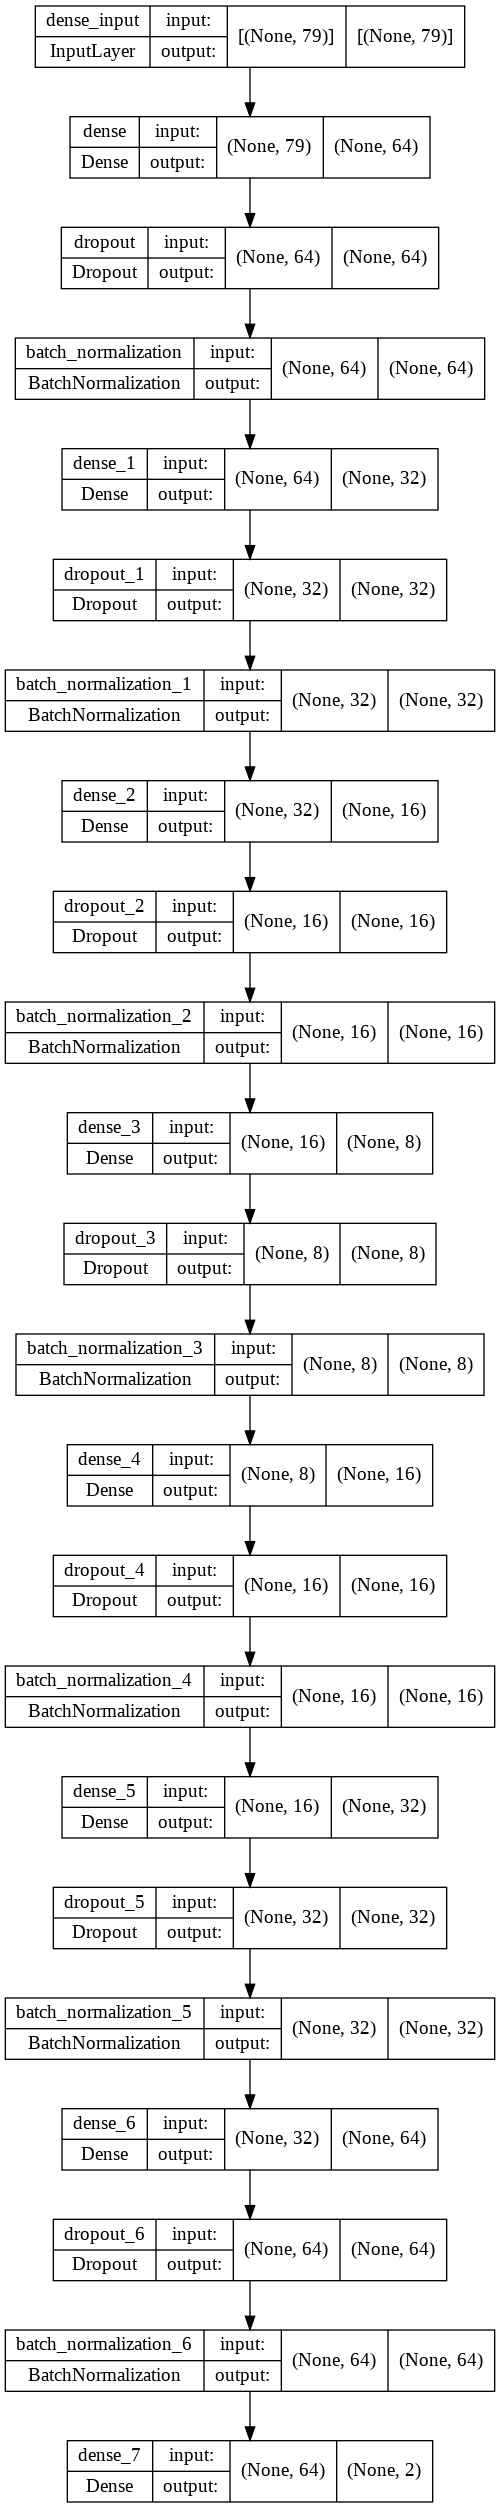

In [ ]:
plot_model(model,to_file='model.png', show_shapes=True)

###Doing prediction using the trained model

In [ ]:
t = model.predict(x_valid[0].reshape(1,79))
t

array([[4.8392988e-04, 8.3635569e-01, 1.5424946e-01, 1.4766293e-03,
        9.1998198e-04, 2.9459279e-03, 3.4451718e-03, 1.2314413e-04]],
      dtype=float32)

In [ ]:
y_valid[0]

array([0, 1, 0, 0, 0, 0, 0, 0])

###Plots

In [ ]:
an_val_acc = [0.792,0.7694,0.7593,0.7653,0.7504,0.7302,0.8119,0.7062,0.8018,0.8143]
an_acc = [0.7962,0.8129,0.8152,0.8165,0.8192,0.8192,0.8201,0.8203,0.8211,0.8212]
an_loss = [0.397,0.3424,0.3335,0.3283,0.3233,0.3222,0.3195,0.3184,0.3161,0.3156]

x_axis = [1,2,3,4,5,6,7,8,9,10]

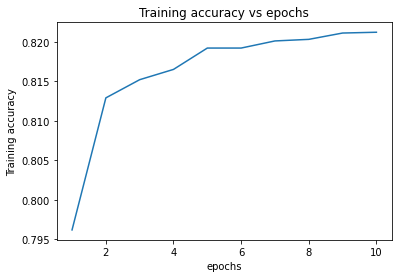

In [ ]:
plt.plot(x_axis, an_acc)
plt.xlabel('epochs')
plt.ylabel('Training accuracy')
plt.title('Training accuracy vs epochs')
plt.show()

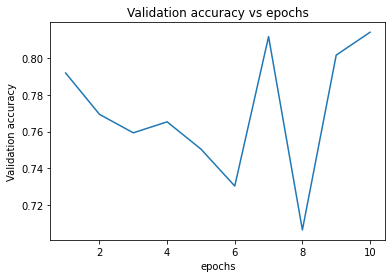

In [ ]:
plt.plot(x_axis, an_val_acc)
plt.xlabel('epochs')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy vs epochs')
plt.show()

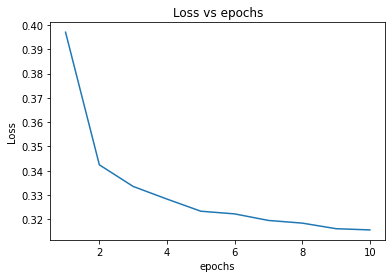

In [ ]:
plt.plot(x_axis, an_loss)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss vs epochs')
plt.show()

*************************************

###Model 2: Variational Autoencoder


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 2

encoder_inputs = keras.Input(shape=(77,))
x = layers.Dense(64,activation="relu",)(encoder_inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dense(8, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8, activation="relu")(latent_inputs)
x = layers.Dense(16,activation="relu")(x)
x = layers.Dense(32,activation="relu")(x)
x = layers.Dense(64,activation="relu")(x)
decoder_outputs = layers.Dense(77,activation="relu")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

final_inputs = keras.Input(shape=(77,))
x = layers.Dense(64,activation="relu")(final_inputs)
x = layers.Dense(32,activation="relu")(x)
x = layers.Dense(16,activation="relu")(x)
outputs = layers.Dense(NUM_OF_CLASSES,activation="softmax")(x)
clf = keras.Model(final_inputs, outputs, name="classifier")

class VAE(keras.Model):
    def __init__(self, encoder, decoder, classifier, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.acc_tracker = keras.metrics.CategoricalAccuracy(name="acc")
        self.reconstruction_loss_tracker = keras.metrics.CategoricalAccuracy(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        # self.classifier_loss_tracker = keras.metrics.categorical_crossentropy(name="classifier_loss")
    
    def call(self,data):
      z_mean, z_log_var, z = self.encoder(data)
      reconstruction = self.decoder(z)
      output = self.classifier(reconstruction)
      return output
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.acc_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data[0])
            reconstruction = self.decoder(z)
            output = self.classifier(reconstruction)
            # reconstruction_loss = tf.reduce_mean(
            #     tf.reduce_sum(
            #         keras.losses.categorical_crossentropy(data[0], reconstruction), axis=1
            #     )
            # )
            reconstruction_loss =  keras.losses.categorical_crossentropy(data[0], reconstruction)
            classifier_loss = keras.losses.categorical_crossentropy(data[1],output)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss + classifier_loss
            # total_loss =  kl_loss + classifier_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(data[0],reconstruction)
        self.kl_loss_tracker.update_state(kl_loss)
        self.acc_tracker.update_state(data[1],output)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "accuracy": self.acc_tracker.result()
        }

    def test_step(self,data):
      z_mean, z_log_var, z = self.encoder(data[0])
      reconstruction = self.decoder(z)
      output = self.classifier(reconstruction)
      classifier_loss = keras.losses.categorical_crossentropy(data[1],output)
      # reconstruction_loss = tf.reduce_mean(
      #           tf.reduce_sum(
      #               keras.losses.categorical_crossentropy(data[0], reconstruction), axis=1
      #           )
      #       )
      reconstruction_loss =  keras.losses.categorical_crossentropy(data[0], reconstruction)
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
      total_loss = reconstruction_loss + kl_loss + classifier_loss
      # total_loss =  kl_loss + classifier_loss
      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(data[0],output)
      self.kl_loss_tracker.update_state(kl_loss)
      self.acc_tracker.update_state(data[1],output)
      return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "acc": self.acc_tracker.result()
        }

In [ ]:
vae = VAE(encoder, decoder,clf)
vae.compile(
    optimizer=keras.optimizers.Adam(lr=0.002))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
vae.fit( 
      x_train,y_train,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_valid,y_valid)
    )

Epoch 1/10
8395/8395 [==============================] - 46s 5ms/step - loss: 49.7464 - reconstruction_loss: 0.9966 - kl_loss: 0.9408 - accuracy: 0.4012 - val_loss: 46.0307 - val_reconstruction_loss: 0.0582 - val_kl_loss: 1.2653 - val_acc: 0.6287
Epoch 2/10
8395/8395 [==============================] - 39s 5ms/step - loss: 45.5834 - reconstruction_loss: 0.9991 - kl_loss: 1.2570 - accuracy: 0.6150 - val_loss: 45.9232 - val_reconstruction_loss: 0.0697 - val_kl_loss: 1.2749 - val_acc: 0.6287
Epoch 3/10
8395/8395 [==============================] - 35s 4ms/step - loss: 45.5069 - reconstruction_loss: 0.9991 - kl_loss: 1.2946 - accuracy: 0.6339 - val_loss: 45.8933 - val_reconstruction_loss: 0.0582 - val_kl_loss: 1.3207 - val_acc: 0.6467
Epoch 4/10
8395/8395 [==============================] - 40s 5ms/step - loss: 45.4930 - reconstruction_loss: 0.9991 - kl_loss: 1.3261 - accuracy: 0.6445 - val_loss: 45.8927 - val_reconstruction_loss: 0.0573 - val_kl_loss: 1.3835 - val_acc: 0.6635
Epoch 5/10
8395/

In [ ]:
t = vae.predict(x_valid)

In [ ]:
t = vae.predict(test_df.to_numpy().reshape(1,77))
t

array([[0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
true_labels = tf.argmax(y_valid, axis = 1)
preds = tf.argmax(t, axis = 1)

In [ ]:
cm = confusion_matrix(true_labels,preds)

In [ ]:
cmd = ConfusionMatrixDisplay(cm, display_labels=list(np.unique(train_df.iloc[:,-1])))

[Text(0, 0.5, 'True'), Text(0.5, 0, 'Predicted')]

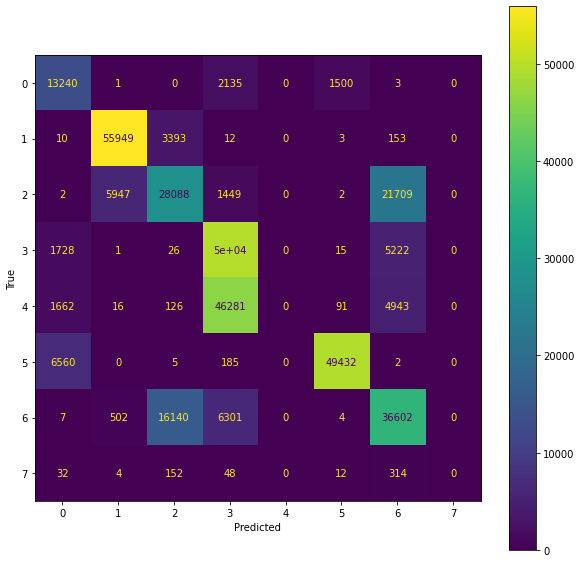

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)
cmd.ax_.set(xlabel='Predicted', ylabel='True')

###Plots

In [ ]:
vae_val_acc = [0.573,0.611,0.5906,0.5865,0.6387,0.6268,0.6231,0.6293,0.6366,0.6306]
vae_acc = [0.3385,0.6008,0.6235,0.6205,0.6226,0.6215,0.6142,0.6265,0.6301,0.6313]
vae_loss = [41.06,37.31,37.297,36.96,37.002,36.9986,36.9986,36.9319,36.9478,35.69]

x_axis = [1,2,3,4,5,6,7,8,9,10]

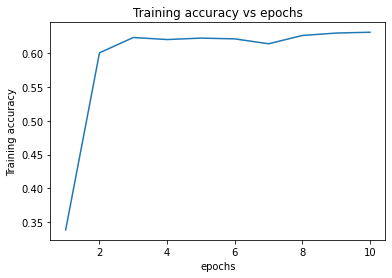

In [ ]:
plt.plot(x_axis, vae_acc)
plt.xlabel('epochs')
plt.ylabel('Training accuracy')
plt.title('Training accuracy vs epochs')
plt.show()

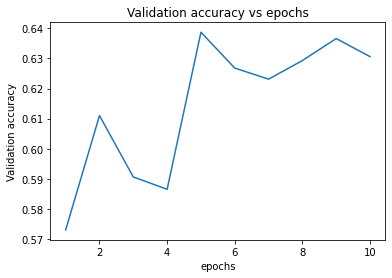

In [ ]:
plt.plot(x_axis, vae_val_acc)
plt.xlabel('epochs')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy vs epochs')
plt.show()

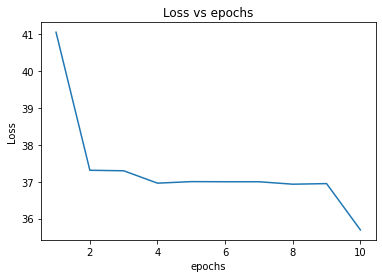

In [ ]:
plt.plot(x_axis, vae_loss)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss vs epochs')
plt.show()

***************************************************

###ML models



###Gradient Boosting

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=0.8,max_depth=3, random_state=0).fit(x_train, y_train)

In [ ]:
clf.score(x_valid, y_valid)

0.7980895402886818

###XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [ ]:
xgb_cl = xgb.XGBClassifier(learning_rate=0.8,max_depth=3)

In [ ]:
xgb_cl.fit(x_train, y_train)

XGBClassifier(learning_rate=0.8, objective='multi:softprob')

In [ ]:
preds = xgb_cl.predict(x_valid)

In [ ]:
accuracy_score(y_valid, preds)

0.6583766542284065

###CatBoost


In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
clf = CatBoostClassifier(
    learning_rate=0.3,
    iterations=20  
    #loss_function='CrossEntropy'
)

In [ ]:
clf.fit(
    x_train, y_train,
    eval_set=(x_valid, y_valid),
)

0:	learn: 0.8201445	test: 0.8211217	best: 0.8211217 (0)	total: 5.86s	remaining: 1m 51s
1:	learn: 0.6319750	test: 0.6330147	best: 0.6330147 (1)	total: 10.8s	remaining: 1m 37s
2:	learn: 0.5172719	test: 0.5186911	best: 0.5186911 (2)	total: 16.4s	remaining: 1m 32s
3:	learn: 0.4454301	test: 0.4469395	best: 0.4469395 (3)	total: 21.7s	remaining: 1m 26s
4:	learn: 0.3979585	test: 0.3994947	best: 0.3994947 (4)	total: 26.2s	remaining: 1m 18s
5:	learn: 0.3621097	test: 0.3636720	best: 0.3636720 (5)	total: 29.3s	remaining: 1m 8s
6:	learn: 0.3365392	test: 0.3380450	best: 0.3380450 (6)	total: 31.5s	remaining: 58.6s
7:	learn: 0.3164597	test: 0.3179745	best: 0.3179745 (7)	total: 33.4s	remaining: 50.2s
8:	learn: 0.3026180	test: 0.3042243	best: 0.3042243 (8)	total: 35.1s	remaining: 42.9s
9:	learn: 0.2915173	test: 0.2928622	best: 0.2928622 (9)	total: 37s	remaining: 37s
10:	learn: 0.2793327	test: 0.2805775	best: 0.2805775 (10)	total: 38.9s	remaining: 31.8s
11:	learn: 0.2735486	test: 0.2747774	best: 0.274777

In [ ]:
clf.save_model('cat_boost',format='cbm')

In [ ]:
t = CatBoostClassifier()
t.load_model('cat_boost')

In [ ]:
preds = t.predict(x_valid)
accuracy_score(y_valid, preds)

0.8642051139521957

In [ ]:
!ls

cat_boost  catboost_info  drive  sample_data


In [ ]:
preds = clf.predict(scaler.transform(test_df.to_numpy()))
# accuracy_score(y_valid, preds)
preds

array([[0]])

In [ ]:
preds = clf.predict(x_valid)
accuracy_score(y_valid, preds)

0.8657951997065468

In [ ]:
cm = confusion_matrix(y_valid,preds)

array([[16874,     0,     2,     5,    20,     0,     0,     0],
       [   12, 58968,   553,     1,     4,     0,     0,     0],
       [    6,  1261, 55345,     0,     9,     0,   467,     0],
       [    4,     0,    16, 21074, 35650,     0,   107,     0],
       [   59,     0,   176,  7734, 45120,     6,    74,     0],
       [   16,     0,     4,     0,     0, 56145,     1,     0],
       [    3,     0,  1584,     0,     3,     1, 57985,     2],
       [   34,     0,    38,     0,    19,     2,   421,    48]])

In [ ]:
cmd = ConfusionMatrixDisplay(cm, display_labels=list(np.unique(train_df.iloc[:,-1])))

[Text(0, 0.5, 'True'), Text(0.5, 0, 'Predicted')]

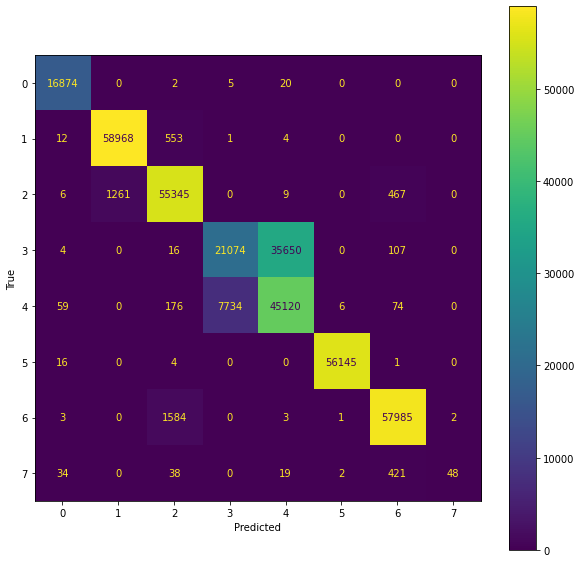

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)
cmd.ax_.set(xlabel='Predicted', ylabel='True')

In [ ]:
x = clf.predict(x_valid[:10])
x

array([[1],
       [3],
       [5],
       [6],
       [1],
       [2],
       [3],
       [6],
       [6],
       [2]])

In [ ]:
y_valid[:10]

array([1, 3, 5, 6, 1, 2, 4, 6, 6, 2])

###LGBM classifier

In [ ]:
import lightgbm as lgb

In [ ]:
clf = lgb.LGBMClassifier()

In [ ]:
clf.fit(x_train, y_train)

LGBMClassifier()

In [ ]:
preds=clf.predict(x_valid)
accuracy_score(y_valid, preds)

0.8700441569196311

In [ ]:
cm = confusion_matrix(y_valid,preds)

In [ ]:
cmd = ConfusionMatrixDisplay(cm, display_labels=list(np.unique(train_df.iloc[:,-1])))

[Text(0, 0.5, 'True'), Text(0.5, 0, 'Predicted')]

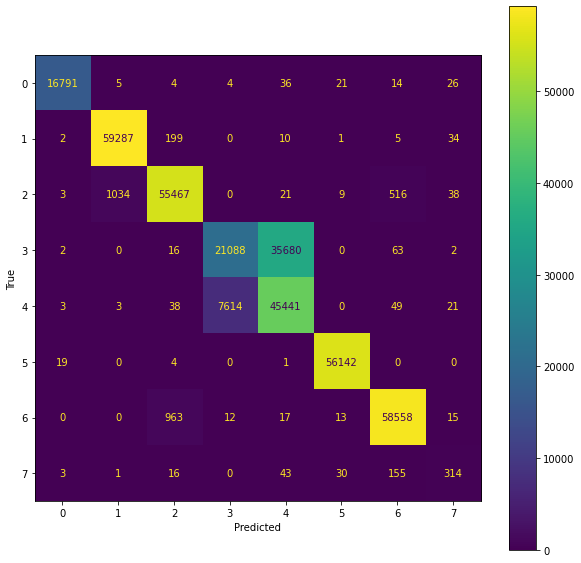

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)
cmd.ax_.set(xlabel='Predicted', ylabel='True')